In [22]:
# Install & Import Libraries

In [23]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files


In [24]:
# Upload and Unzip Dataset

In [25]:
uploaded = files.upload()

with zipfile.ZipFile("project1_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("project1_dataset")

data_dir = "/content/project1_dataset/project1_dataset/"


Saving project1_dataset.zip to project1_dataset (2).zip


In [26]:
#Set Up Image Data Generators with Augmentation

In [28]:
img_height, img_width = 128, 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

class_names = ['glass', 'metal', 'plastic', 'wood']

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=class_names,
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=class_names,
    shuffle=False
)


Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [29]:
# Build CNN Model

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
# Train the Model with Early Stopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 984ms/step - accuracy: 0.4776 - loss: 1.3310 - val_accuracy: 0.8250 - val_loss: 0.5454
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - accuracy: 0.7692 - loss: 0.5649 - val_accuracy: 0.9000 - val_loss: 0.2883
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 806ms/step - accuracy: 0.8489 - loss: 0.3537 - val_accuracy: 0.9625 - val_loss: 0.1836
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.9078 - loss: 0.2278 - val_accuracy: 0.9625 - val_loss: 0.1443
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 805ms/step - accuracy: 0.9045 - loss: 0.2924 - val_accuracy: 0.9625 - val_loss: 0.1323
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.9428 - loss: 0.1729 - val_accuracy: 0.9875 - val_loss: 0.1186
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - accuracy: 0.9588 - loss: 0.1467 - val_accuracy: 0.9625 - val_loss: 0.1140
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step - accuracy: 0.9671 - loss: 0.1369 - val_accuracy: 

In [33]:
#Evaluate Model

In [34]:
val_data.reset()
preds = model.predict(val_data)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

print("Class indices:", val_data.class_indices)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 905ms/step
Class indices: {'glass': 0, 'metal': 1, 'plastic': 2, 'wood': 3}
Classification Report:
              precision    recall  f1-score   support

       glass       1.00      0.95      0.97        20
       metal       0.95      0.95      0.95        20
     plastic       0.95      1.00      0.98        20
        wood       1.00      1.00      1.00        20

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80

Confusion Matrix:
[[19  1  0  0]
 [ 0 19  1  0]
 [ 0  0 20  0]
 [ 0  0  0 20]]


In [35]:
#Prediction of New Image

In [36]:
from tensorflow.keras.preprocessing import image

def predict_material(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    classes = list(train_data.class_indices.keys())
    return classes[class_idx]


In [37]:
model.save("material_classifier.h5")

In [38]:
predict_material('/content/project1_dataset/project1_dataset/glass/image_0011_g.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'glass'

In [39]:
!ls /content/project1_dataset/project1_dataset/wood/image_0001_w.jpg

/content/project1_dataset/project1_dataset/wood/image_0001_w.jpg


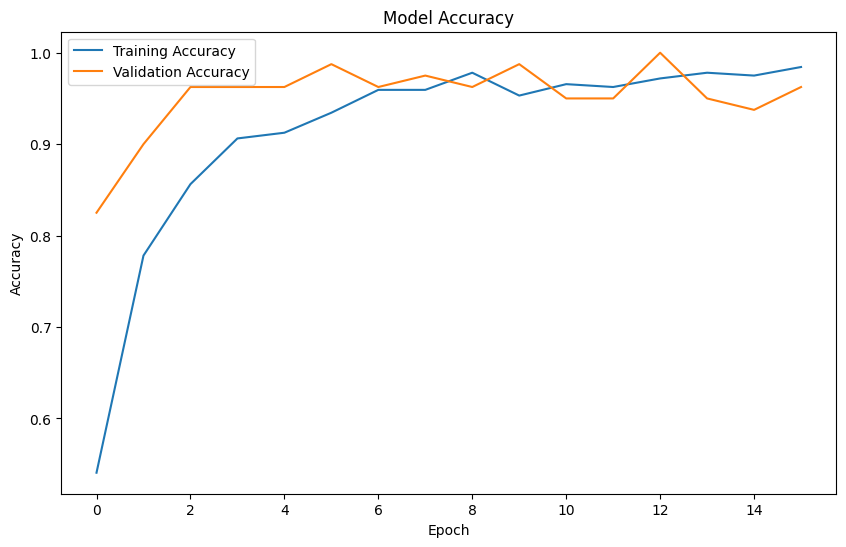

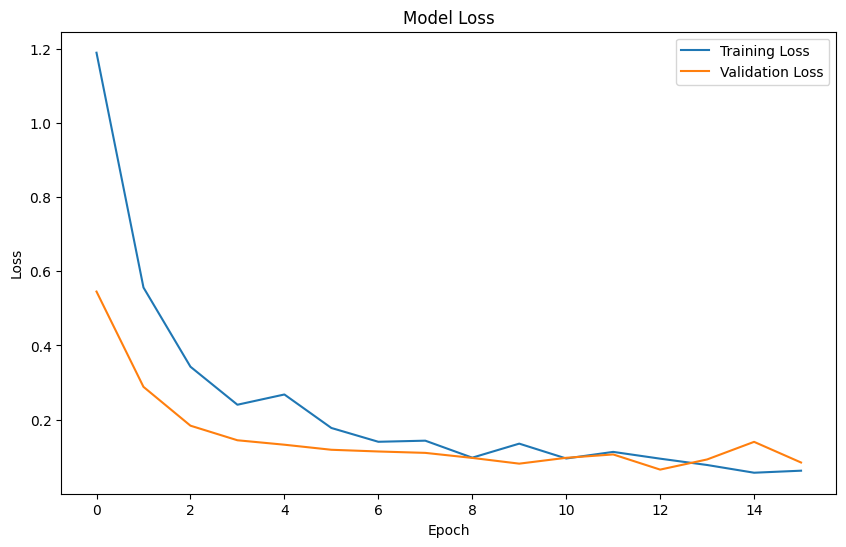

In [40]:
# prompt: plot line that shows accuracy of model

import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

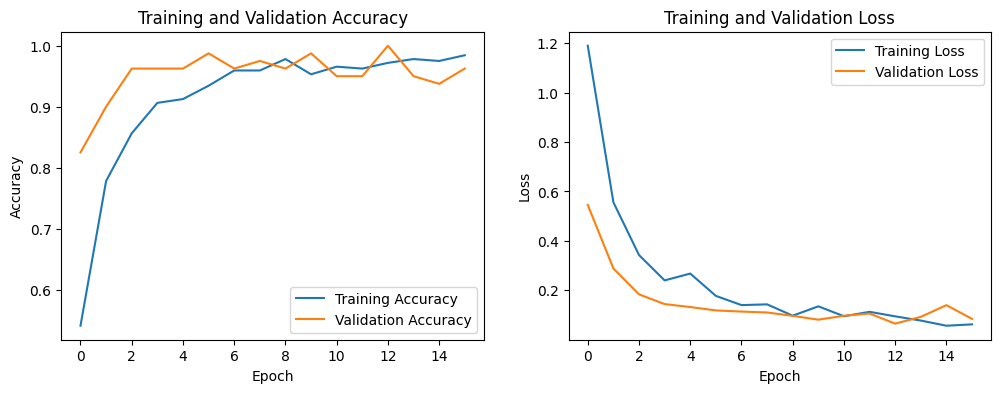

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


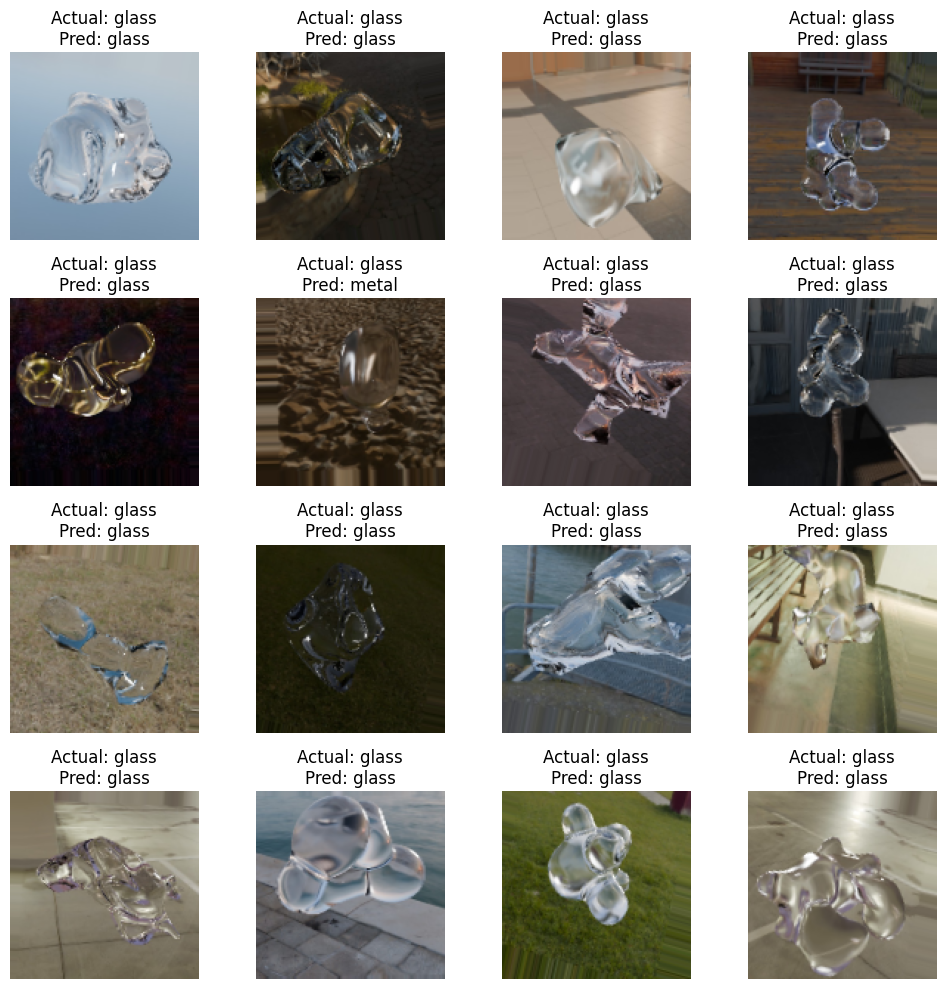

In [41]:
# prompt: generate a line graph that shows the actual classfication vs. prediction

import matplotlib.pyplot as plt
import numpy as np
# Visualize training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot actual vs. predicted (example for the validation set)
# This creates a scatter plot, not a line graph showing classification vs. prediction directly.
# A line graph usually shows performance over time or across a range.
# For classification, visualization typically involves confusion matrices or classification reports.
# If you want to see how predictions align with actual values, a confusion matrix is more suitable.

# Example of visualizing a few predictions vs actual values:
# Get a batch from the validation data to visualize a sample
val_data.reset()
x_val_sample, y_val_sample = next(val_data)
preds_sample = model.predict(x_val_sample)
y_pred_sample = np.argmax(preds_sample, axis=1)
y_true_sample = np.argmax(y_val_sample, axis=1)

plt.figure(figsize=(10, 10))
for i in range(min(16, len(x_val_sample))): # Visualize up to 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_val_sample[i])
    actual_label = class_names[y_true_sample[i]]
    predicted_label = class_names[y_pred_sample[i]]
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()